In [1]:
import argparse
import copy

import matplotlib.pyplot as plt
import tensorflow as tf
import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.signal.gates as gates
from c3.c3objs import Quantity as Qty
from c3.experiment import Experiment as Exp
from c3.generator.generator import Generator as Gnr
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.parametermap import ParameterMap as PMap
from c3.utils import qt_utils
from utils import *

2021-10-26 19:25:56.112556: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-26 19:25:56.112604: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("output", help="Output directory")
args = parser.parse_args()
output_dir = args.output
#output_dir = "./output_0"

usage: ipykernel_launcher.py [-h] output
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/home/user/c3/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# Qubits
qubit_lvls = [4, 4]
numActiveLevels = 4
frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -300e6]
t1 = [27e-6, 27e-6]
t2star = [39e-6, 39e-6]
qubit_temp = [50e-3, 50e-3]

qubits = []
for i in range(len(qubit_lvls)):
    qubits.append(chip.Qubit(
        name=f"Q{i + 1}",
        desc=f"Qubit {i + 1}",
        freq=Qty(
            value=frequencies[i],
            min_val=frequencies[i] - 5e6,
            max_val=frequencies[i] + 5e6,
            unit='Hz 2pi'
        ),
        anhar=Qty(
            value=anharmonicities[i],
            min_val=-380e6,
            max_val=-120e6,
            unit='Hz 2pi'
        ),
        hilbert_dim=qubit_lvls[i],
        t1=Qty(
            value=t1[i],
            min_val=1e-6,
            max_val=90e-6,
            unit='s'
        ),
        t2star=Qty(
            value=t2star[i],
            min_val=10e-6,
            max_val=90e-3,
            unit='s'
        ),
        temp=Qty(
            value=qubit_temp[i],
            min_val=0.0,
            max_val=0.12,
            unit='K'
        )
    ))

['Q0', 'Q1']


In [4]:
# Coupling
coupling_strength = 10e6
q1q2 = chip.Coupling(
    name="Q1-Q2",
    desc="coupling",
    comment="Coupling qubit 1 to qubit 2",
    connected=[qubits[0].name, qubits[1].name],
    strength=Qty(
        value=coupling_strength,
        min_val=-1e3 ,
        max_val=200e6 ,
        unit='Hz 2pi'
    ),
    hamiltonian_func=hamiltonians.int_XX
)

In [5]:
# Drive hamiltonians
drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=[qubits[0].name],
    hamiltonian_func=hamiltonians.x_drive
)
drive2 = chip.Drive(
    name="d2",
    desc="Drive 2",
    comment="Drive line 2 on qubit 2",
    connected=[qubits[1].name],
    hamiltonian_func=hamiltonians.x_drive
)

In [6]:
# Errors and additional components

init_temp = 50e-3
init_ground = tasks.InitialiseGround(
    init_temp=Qty(
        value=init_temp,
        min_val=-0.001,
        max_val=0.22,
        unit='K'
    )
)

In [7]:
# Set up the model
model = Mdl(qubits, [drive, drive2, q1q2])
model.set_lindbladian(False)
model.set_dressed(True)

In [8]:
# Control line
sim_res = 100e9  # Resolution for numerical simulation
awg_res = 2e9  # Realistic, limited resolution of an AWG
generator = Gnr(
    devices={
        "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
        "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
        "DigitalToAnalog": devices.DigitalToAnalog(
            name="dac",
            resolution=sim_res,
            inputs=1,
            outputs=1
        ),
        "Response": devices.Response(
            name='resp',
            rise_time=Qty(
                value=0.3e-9,
                min_val=0.05e-9,
                max_val=0.6e-9,
                unit='s'
            ),
            resolution=sim_res,
            inputs=1,
            outputs=1
        ),
        "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
        "VoltsToHertz": devices.VoltsToHertz(
            name='v_to_hz',
            V_to_Hz=Qty(
                value=1e9,
                min_val=0.9e9,
                max_val=1.1e9,
                unit='Hz/V'
            ),
            inputs=1,
            outputs=1
        )
    },
    chains={
        "d1": ["LO", "AWG", "DigitalToAnalog", "Response", "Mixer", "VoltsToHertz"],
        "d2": ["LO", "AWG", "DigitalToAnalog", "Response", "Mixer", "VoltsToHertz"]
    }
)

In [9]:
# Gate
t_final = 15e-9   # Time for single qubit gates
sideband = 50e6
sigma = t_final / 15
sigma2 = sigma / 2
relative_amp = 2
pwc_times = tf.linspace(0.0, t_final, 30)

gauss_params_single = {
    'amp': Qty(
        value=0.5,
        min_val=0.2,
        max_val=0.6,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'sigma': Qty(
        value=t_final / 4,
        min_val=t_final / 8,
        max_val=t_final / 2,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}
gauss_env_single = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm
)
pwc_values = tf.exp(-((pwc_times - t_final / 2) ** 2) / (2 * sigma ** 2)) - tf.exp(
    -((pwc_times - t_final / 2) ** 2) / (2 * sigma2 ** 2)) * relative_amp
pwc_values2 = tf.zeros_like(pwc_values)
pwc_env = pulse.Envelope(
    name="pwc",
    desc="PWC envelope",
    params={
        "amp": Qty(value=0.5, min_val=0.2, max_val=0.6, unit="V"),
        "t_final": Qty(value=t_final, min_val=0.9 * t_final, max_val=1.1 * t_final, unit="s"),
        "xy_angle": Qty(value=0.0, min_val=-1.5 * np.pi, max_val=2.5 * np.pi, unit="rad"),
        "freq_offset": Qty(value=-53e6, min_val=-56e6, max_val=-52e6, unit="Hz 2pi"),
        "delta": Qty(value=-1, min_val=-5, max_val=5, unit=""),
        "t_bin_start": Qty(0),
        "t_bin_end": Qty(t_final),
        "inphase": Qty(pwc_values),
    },
    shape=envelopes.pwc_shape,
)
pwc_env2 = pulse.Envelope(
    name="pwc2",
    desc="PWC envelope",
    params={
        "amp": Qty(value=0.5, min_val=0.2, max_val=0.6, unit="V"),
        "t_final": Qty(value=t_final, min_val=0.9 * t_final, max_val=1.1 * t_final, unit="s"),
        "xy_angle": Qty(value=0.0, min_val=-1.5 * np.pi, max_val=2.5 * np.pi, unit="rad"),
        "freq_offset": Qty(value=-53e6, min_val=-56e6, max_val=-52e6, unit="Hz 2pi"),
        "delta": Qty(value=-1, min_val=-5, max_val=5, unit=""),
        "t_bin_start": Qty(0),
        "t_bin_end": Qty(t_final),
        "inphase": Qty(pwc_values2),
    },
    shape=envelopes.pwc_shape,
)
nodrive_env = pulse.Envelope(
    name="no_drive",
    params={
        't_final': Qty(
            value=t_final,
            min_val=0.5 * t_final,
            max_val=1.5 * t_final,
            unit="s"
        )
    },
    shape=envelopes.no_drive
)
lo_frequencies = [4.7e9, 4.2e9]
carriers = [pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params={
        'freq': Qty(
            value=freq,
            min_val=0.75 * freq,
            max_val=1.25 * freq,
            unit='Hz 2pi'
        ),
        'framechange': Qty(
            value=0.0,
            min_val=-np.pi,
            max_val=3 * np.pi,
            unit='rad'
        )
    }
) for freq in lo_frequencies]

In [10]:
# Instruction
idealGate = qt_utils.np_kron_n([constants.Id, constants.x90p])
rx90p_q1 = gates.Instruction(
    name="rx90p", targets=[0], t_start=0.0, t_end=t_final, channels=["d1", "d2"],
    ideal=idealGate
)
rx90p_q1.add_component(pwc_env, "d1")
rx90p_q1.add_component(carriers[0], "d1")
rx90p_q1.add_component(pwc_env2, "d2")
rx90p_q1.add_component(carriers[1], "d2")
rx90p_q1.comps["d2"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final) * 2 * np.pi % (2 * np.pi)
)

perfect_gate = rx90p_q1.get_ideal_gate(
    [q.hilbert_dim for q in qubits],
    [q.index for q in qubits],
    active_levels=numActiveLevels
)
plotMatrix(perfect_gate, output_dir + "/ideal_gate.png",
           output_dir + "/ideal_gate_phase.png",
           output_dir + "/ideal_gate_abs.png")

saving plot in ./output_0/ideal_gate.png
saving plot in ./output_0/ideal_gate_phase.png
saving plot in ./output_0/ideal_gate_abs.png


In [11]:
# Set up experiment
parameter_map = PMap(instructions=[rx90p_q1], model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates(['rx90p[0]'])
unitaries = exp.compute_propagators()

psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

2021-10-22 17:16:21.642415: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-22 17:16:21.660428: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793625000 Hz


In [12]:
def plot_dynamics(exp: Experiment, psi_init, seq, filename=None):
    model = exp.pmap.model
    dUs = exp.partial_propagators
    psi_t = psi_init.numpy()
    pop_t = exp.populations(psi_t, model.lindbladian)
    for gate in seq:
        for du in dUs[gate]:
            psi_t = np.matmul(du.numpy(), psi_t)
            pops = exp.populations(psi_t, model.lindbladian)
            pop_t = np.append(pop_t, pops, axis=1)

    fig, axs = plt.subplots(1, 1)
    ts = exp.ts
    dt = ts[1] - ts[0]
    ts = np.linspace(0.0, dt * pop_t.shape[1], pop_t.shape[1])
    axs.plot(ts / 1e-9, pop_t.T)
    axs.grid(linestyle="--")
    axs.tick_params(
        direction="in", left=True, right=True, top=True, bottom=True
    )
    axs.set_xlabel('Time [ns]')
    axs.set_ylabel('Population')
    plt.legend(model.state_labels, ncol=2, bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename)
        plt.close()
    pass


def getOutputFromDevice(gen: Generator, gate: Instruction, channel: str, deviceName: str):
    gen.generate_signals(gate)
    return gen.getDeviceOutput(channel, deviceName)


def getEnvelope(gen: Generator, gate: Instruction, channel: str):
    full_signal = gen.generate_signals(gate)[channel]
    values1 = full_signal["values"].numpy()
    envelope = getOutputFromDevice(gen, gate, channel, "Response")
    values2 = envelope["inphase"].numpy()
    factor = np.max(np.abs(values1)) / np.max(np.abs(values2))
    return envelope["ts"].numpy(), factor * envelope["inphase"].numpy(), factor * envelope["quadrature"].numpy()

In [13]:
sequence = ['rx90p[0]']
signal = generator.generate_signals(rx90p_q1)[drive.name]
plotSignalWithEnvelope(signal["ts"].numpy(), signal["values"].numpy(),
                       getEnvelope(generator, rx90p_q1, drive.name),
                       pwc_times,
                       output_dir + "/signal_before.png",
                       spectrum_cut=1e-4)
plot_dynamics(exp, init_state, sequence, output_dir + "/population_before.png")
plot_dynamics(exp, init_state, sequence * 5, output_dir + "/population_before.png")
plotMatrix(
    exp.propagators[rx90p_q1.get_key()],
    output_dir + "/propagator_before.png",
    output_dir + "/propagator_before_phase.png",
    output_dir + "/propagator_before_abs.png",
    labels=[str(x) for x in model.state_labels]
)

envelope size:  1499 1499
saving plot in ./output_0/signal_before.png
saving plot in ./output_0/propagator_before.png
saving plot in ./output_0/propagator_before_phase.png
saving plot in ./output_0/propagator_before_abs.png


In [14]:
# Optimise
generator.devices['AWG'].enable_drag_2()
opt_gates = ["rx90p[0]"]
gateset_opt_map = [
    #[("rx90p[0]", "d1", "gauss", "amp")],
    #[("rx90p[0]", "d1", "gauss", "freq_offset")],
    #[("rx90p[0]", "d1", "gauss", "xy_angle")],
    #[("rx90p[0]", "d1", "gauss", "delta")],
    [("rx90p[0]", "d1", "pwc", "amp")],
    [("rx90p[0]", "d1", "pwc", "t_final")],
    [("rx90p[0]", "d1", "pwc", "freq_offset")],
    [("rx90p[0]", "d1", "pwc", "xy_angle")],
    [("rx90p[0]", "d1", "pwc", "delta")],
    [("rx90p[0]", "d1", "pwc", "inphase")],
    [("rx90p[0]", "d1", "carrier", "freq")],
    [("rx90p[0]", "d1", "carrier", "framechange")],
    [("rx90p[0]", "d2", "pwc2", "amp")],
    [("rx90p[0]", "d2", "pwc2", "t_final")],
    [("rx90p[0]", "d2", "pwc2", "freq_offset")],
    [("rx90p[0]", "d2", "pwc2", "xy_angle")],
    [("rx90p[0]", "d2", "pwc2", "delta")],
    [("rx90p[0]", "d2", "pwc2", "inphase")],
    [("rx90p[0]", "d2", "carrier", "freq")],
    [("rx90p[0]", "d2", "carrier", "framechange")]
]
parameter_map.set_opt_map(gateset_opt_map)

opt = OptimalControl(
    dir_path=output_dir + "/logs",
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=["Q1", "Q2"],
    fid_func_kwargs={"active_levels": 4},
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun": 300},
    run_name="better_X90"
)
exp.set_opt_gates(opt_gates)
opt.set_callback(lambda fidelity: print(fidelity))
opt.set_exp(exp)
opt.optimize_controls()

C3:STATUS:Saving as: /tmp/tmp3dtq0u4o/c3logs/better_X90/2021_10_22_T_13_32_44/open_loop.log
0.9432404987916637


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/user/c3/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_20635/1824757089.py", line 33, in <module>
    opt.optimize_controls()
  File "/home/user/c3/c3/optimizers/optimalcontrol.py", line 155, in optimize_controls
    self.load_best(self.logdir + "best_point_" + self.logname)
  File "/home/user/c3/c3/optimizers/optimizer.py", line 113, in load_best
    self.pmap.load_values(init_point)
  File "/home/user/c3/c3/parametermap.py", line 77, in load_values
    with open(init_point) as init_file:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp3dtq0u4o/c3logs/better_X90/2021_10_22_T_13_32_44/best_point_open_loop.log'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/user/c3/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", 

TypeError: object of type 'NoneType' has no len()

0.4864735577711987


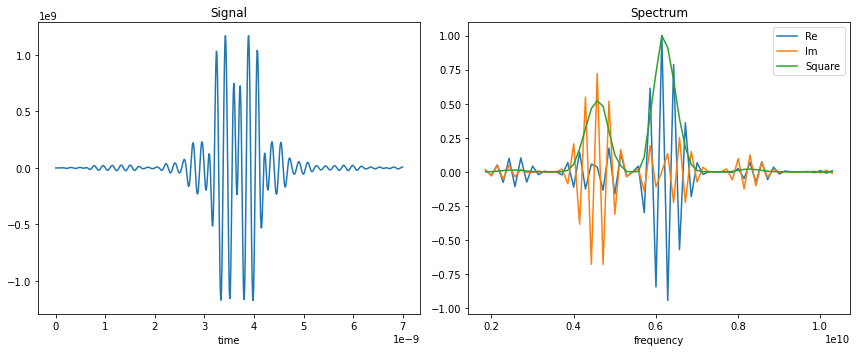

rx90p[0]-d1-pwc-amp                   : 501.129 mV 
rx90p[0]-d1-pwc-t_final               : 7.000 ns 
rx90p[0]-d1-pwc-freq_offset           : -53.009 MHz 2pi 
rx90p[0]-d1-pwc-xy_angle              : 240.960 mrad 
rx90p[0]-d1-pwc-delta                 : -1.210  
rx90p[0]-d1-pwc-inphase               : 6.1e-13  -0.000482  -0.00398  -0.01  0.00636  -0.009  0.0103  0.00196  0.00705  0.0277  0.0596  0.2  0.353  0.139  -0.786  -0.79  0.145  0.354  0.201  0.065  0.0234  0.0108  -0.00348  0.00858  -0.00978  0.00102  -0.00526  -0.00443  0.00222  6.1e-13  
rx90p[0]-d1-carrier-freq              : 5.508 GHz 2pi 
rx90p[0]-d1-carrier-framechange       : -1.968 rad 



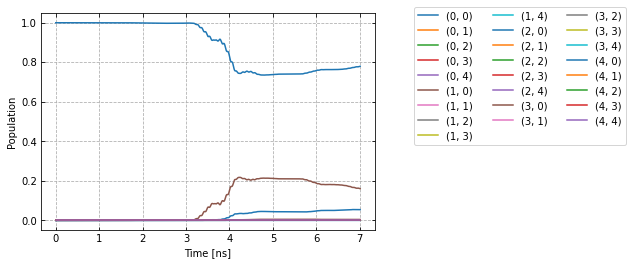

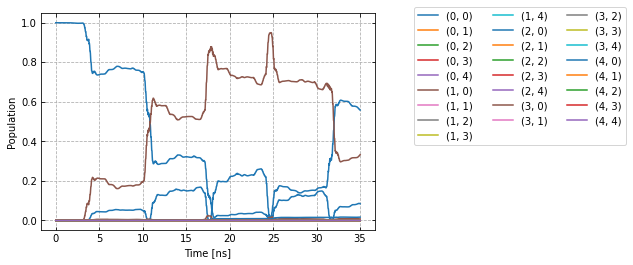

In [20]:
# Print results
print(opt.current_best_goal)
signal = generator.generate_signals(rx90p_q1)[drive.name]
plotSignalWithEnvelope(signal["ts"].numpy(), signal["values"].numpy(),
                       getEnvelope(generator, rx90p_q1, drive.name),
                       pwc_times,
                       output_dir + "/signal_after.png", spectrum_cut=1e-4)
plot_dynamics(exp, init_state, sequence, output_dir + "/population_after.png")
plot_dynamics(exp, init_state, sequence * 5, output_dir + "/population5_after.png")
plotMatrix(
    exp.propagators[rx90p_q1.get_key()],
    output_dir + "/propagator_after.png",
    output_dir + "/propagator_after_phase.png",
    output_dir + "/propagator_after_abs.png",
    labels=[str(x) for x in model.state_labels]
)
plotMatrix(
    exp.propagators[rx90p_q1.get_key()] - perfect_gate,
    output_dir + "/propagator_after_diff.png",
    output_dir + "/propagator_after_diff_phase.png",
    output_dir + "/propagator_after_diff_abs.png",
    labels=[str(x) for x in model.state_labels]
)
parameter_map.print_parameters()